In [1]:
# Importo librerías:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multidict as multidict
import re, requests, nltk, string
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

In [2]:
# Web principal:
url = "https://www.themoscowtimes.com/"

# Extraemos la info de cada apartado en la web, empezando por News:

# News:
response = requests.get(url+"news")
soup = BeautifulSoup(response.text, "html.parser")
titles_container = soup.findAll('h3', {'class': 'article-excerpt-default__headline'})

titles_info = [title.text for title in titles_container]

In [3]:
# News+Opinion:
response = requests.get(url+"opinion")
titles_info = str(titles_info) + str([title.text for title in titles_container])

In [4]:
# News+Opinion+Business:
response = requests.get(url+"business")
titles_info = str(titles_info) + str([title.text for title in titles_container])

In [5]:
# News+Opinion+Business+ArtAndLife:
response = requests.get(url+"arts-and-life")
titles_info = str(titles_info) + str([title.text for title in titles_container])

In [6]:
# News+Opinion+Business+ArtAndLife+Meanwhile:
response = requests.get(url+"meanwhile")
titles_info = str(titles_info) + str([title.text for title in titles_container])

In [7]:
# News+Opinion+Business+ArtAndLife+Meanwhile+InDepth:
response = requests.get(url+"in-depth")
titles_info = str(titles_info) + str([title.text for title in titles_container])

In [8]:
# Limpiamos signos de puntuación:
def replace_punctuation (text, replace):
      return re.sub("[%s]" % re.escape(string.punctuation), replace, text)

titles_info = replace_punctuation(str(titles_info), "")

In [9]:
# Limpiamos otros caracteres:
titles_info = titles_info.replace("’", "").replace("‘", "").replace("'", "").replace("\n","").replace(
    "\t","").replace("\\ ", "").replace("–", "")

In [10]:
# Todo a minúscula:
titles_info = titles_info.lower()

In [11]:
# Visualizamos parte del resultado:
titles_info[:1001]

'an overview of russian laws coming into effect this month russian football fan jailed for punching riot police officer in stadium brawl war robs donetsk of its proud footballing tradition russias alcohol consumption plummets more than 40  who study senior investigator stabbed to death in moscow russia escalates clampdown on north korean fishermen with new detentions  russia test launches new intercontinental ballistic missile  video russia invites climate activist greta thunberg to speak in parliament st petersburg authorities paid local athletes to beat and threaten election observers  meduza russian nuclear engineer fined for mining bitcoin at topsecret lab us sanctions 2 russians connected to kremlin troll factory russian veterans hospital bans transgender hairstylist from charity project russia plans reusable rocket to compete with elon musk by 2024  rbc trumpputin phone calls can only be disclosed with russian consent kremlin says most russians charged for disrespecting authoriti

In [12]:
# Limpiamos tokenizando y sacando las stopwords:
# Token list: (listamos palabras)
words = nltk.tokenize.word_tokenize(titles_info)

# Stopwords list: (palabras vacías = artículos, pronombres, preposiciones, etc.)
stopwords = nltk.corpus.stopwords.words("english")

# Token list - stopwords:
words_without_stopwords = list(filter(lambda word: word not in stopwords, words))

In [13]:
# Listado frecuencia de las palabras resultantes:
words_except_stop_dist = nltk.FreqDist(words_without_stopwords)

Top 10 frequencies, excluding stopwords:
---------------------------------------------
         Value  Frequency
0      russian         36
1       russia         36
2       police         12
3          new         12
4  authorities         12
5     russians         12
6      kremlin         12
7        calls         12
8     overview          6
9         laws          6
---------------------------------------------


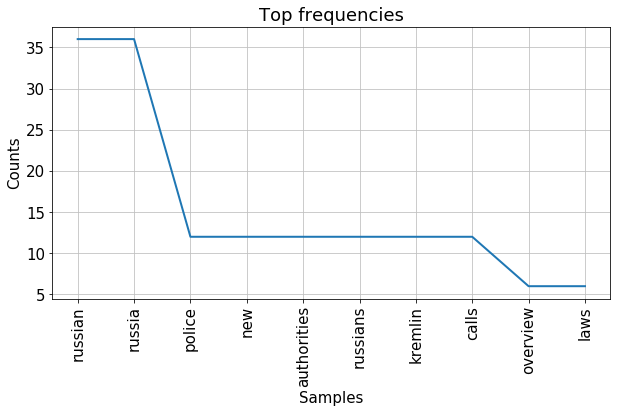

In [14]:
# Resultado en valores y gráfica:
def print_df_and_graph_of_freqdist(top, freqdist):
    #df:
    print("Top", top, "frequencies, excluding stopwords:")
    print("-" * 45)
    print(pd.DataFrame(freqdist.most_common(top), columns = ["Value", "Frequency"]))
    print("-" * 45)
     #graph:   
    plt.figure(figsize=(10,5)) #Change graph size
    plt.rcParams.update({'font.size': 15}) #Change text size
    freqdist.plot(top, title = "Top frequencies")

print_df_and_graph_of_freqdist(10, words_except_stop_dist)

In [15]:
'''Etiquetamos las palabras con idea de deshacernos de aquella clase que no nos aporte info. 
(+info en https://www.sketchengine.eu/penn-treebank-tagset/)'''
word_tags = nltk.pos_tag(words_without_stopwords) # Devuelve una lista
word_tags = pd.DataFrame(word_tags, columns = ["Word", "Tag"]) # Lo pasamos a df

word_tags.head(10)

,Word,Tag
0,overview,NN
1,russian,JJ
2,laws,NNS
3,coming,VBG
4,effect,NN
5,month,NN
6,russian,JJ
7,football,NN
8,fan,NN
9,jailed,VBD


In [16]:
# Eliminamos los verbos:
def delete_tag_in_df(df, column, tag): # Startswith!
    df.drop(df[df[column].str.startswith(tag)].index.tolist(), inplace = True)
    
# Eliminamos valores como "russia", "russian", etc.:
def delete_family_in_df(df, column, family):
    df.drop(df[df[column].str.startswith(family)].index.tolist(), inplace = True)
    
delete_tag_in_df(word_tags, "Tag" , "VB")
delete_tag_in_df(word_tags, "Tag" , "JJ")
delete_tag_in_df(word_tags, "Tag", "CD")
delete_family_in_df(word_tags, "Word" , "rus")

Top 10 frequencies, excluding stopwords:
---------------------------------------------
         Value  Frequency
0       police         12
1  authorities         12
2      kremlin         12
3         laws          6
4       effect          6
5        month          6
6     football          6
7          fan          6
8         riot          6
9      officer          6
---------------------------------------------


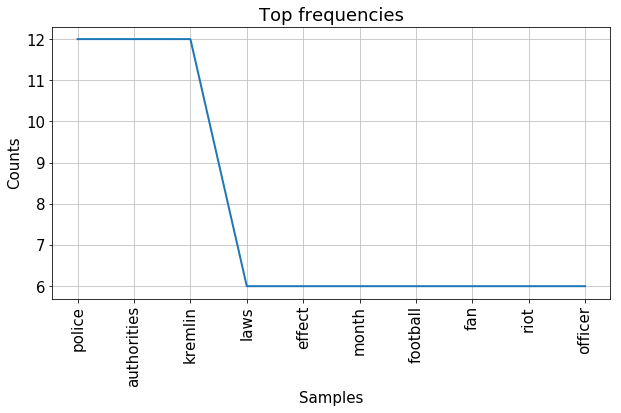

In [17]:
# Listado de frecuencias sin verbos ni familia "russia":
final_words_list = word_tags["Word"].values.tolist()
final_words = nltk.FreqDist(final_words_list)

# Resultado:
print_df_and_graph_of_freqdist(10, final_words)

Top 10 frequencies, excluding stopwords:
---------------------------------------------
         Value  Frequency
0       police         12
1  authorities         12
2      kremlin         12
3         laws          6
4       effect          6
5        month          6
6     football          6
7          fan          6
8         riot          6
9      officer          6
---------------------------------------------


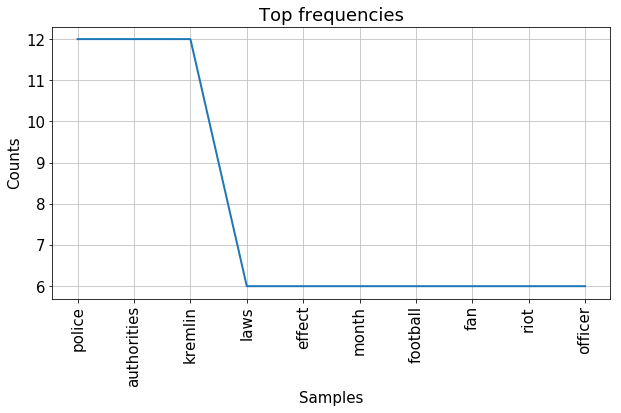

In [18]:
# Revisando la nube de palabras final veo que me ha separado nombres+apellidos y nombres de ciudades, unifico:
word_tags["Word"] = word_tags["Word"].replace({'greta': 'gretathunberg', 'petersburg': 'stpetersburg',
                                               'elon': 'elonmusk'})

# Eliminamos los otros para evitar duplicar frecuencia:
word_tags["Word"] = word_tags["Word"].replace({'thunberg': None, 'st': None, 'musk': None})
word_tags.dropna(inplace=True)

# Listado de frecuencias con arreglo del día:
final_words_list = word_tags["Word"].values.tolist()
final_words = nltk.FreqDist(final_words_list)

# Resultado:
print_df_and_graph_of_freqdist(10, final_words)

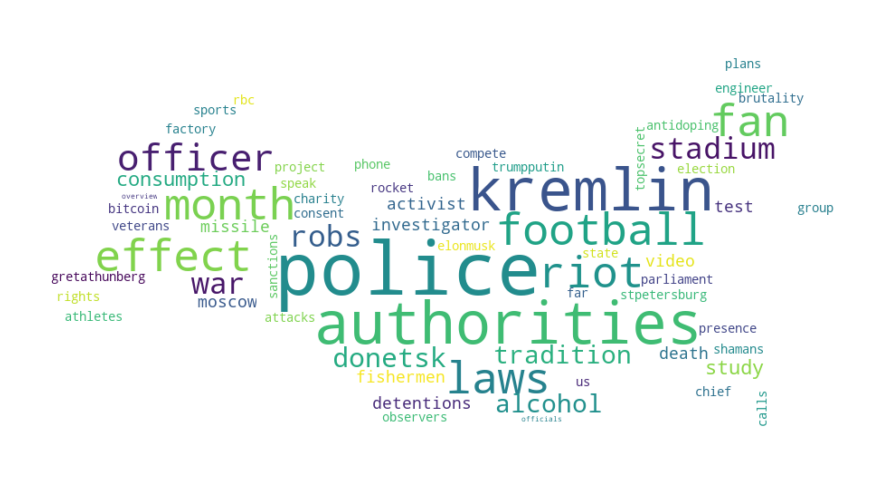

In [19]:
# Visualizamos en formato nube de palabras: +info en: 
# https://amueller.github.io/word_cloud/auto_examples/frequency.html#sphx-glr-auto-examples-frequency-py)

def getFrequencyDictForText(lista):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # Pasamos a diccionario:
    for word in lista:
        value = tmpDict.get(word, 0)
        tmpDict[word] = value + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict


def makeImage(diccionario):
    russian_map_mask = np.array(Image.open(requests.get("https://n9.cl/2s8p", stream = True).raw))

    # Generamos la WordCloud:
    word_cloud = WordCloud(background_color="white", max_words=1000, mask=russian_map_mask)
    word_cloud.generate_from_frequencies(diccionario)

    plt.figure(figsize = (12, 12),facecolor = None)
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    
makeImage(getFrequencyDictForText(final_words_list))